# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
 -1
  1
  1
 -1
  1
  1
  1
 -1
  1
  ⋮
  1
  1
  1
 -1
  1
 -1
 -1
  1
 -1

### We create a function to visualize the data

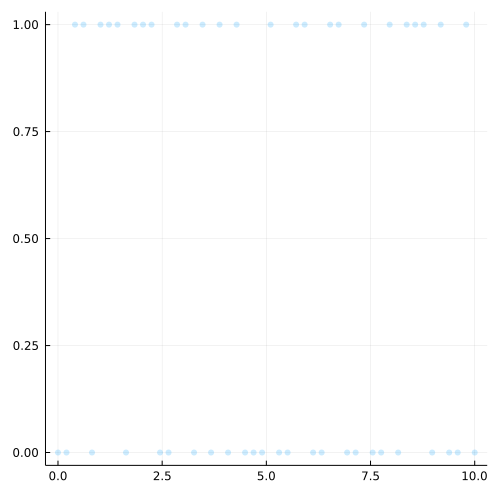

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.143646 seconds (1.82 M allocations: 103.711 MiB, 13.82% gc time, 99.60% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink()) infered by Analytic Variational Inference , (local_vars = (c = [0.7366234190383298, 0.6811396093865092, 0.6572330683931102, 0.6746043314840956, 0.7243914674224584, 0.7858576297235893, 0.8386619238531698, 0.8700018878684621, 0.8751191813692418, 0.8562533750629842  …  0.6071321926114933, 0.6162051600479005, 0.620450231507323, 0.6168971126161926, 0.6096122702253732, 0.6087702427904172, 0.6248461085552851, 0.6616553291718853, 0.71416918182344, 0.7730350881660301], θ = [0.23927701123237616, 0.2407626816474299, 0.24137337218264, 0.24093141795843065, 0.23961258785539918, 0.2378817548796889, 0.23630895984055847, 0.23533982360168512, 0.23517913893733355, 0.23576816046191604  …  0.2425935257922485, 0.24237865878307718, 0.2422771918531579, 0.24236216007680195, 0.2425350633937953, 0.24255493525615981, 0.2421714952044954, 0.24126177189511933, 0.23988957462936195, 0.23825189965570395]),

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:35
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:03:00
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:02:00
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:29
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:11
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:59
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:51
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:39
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:35
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:32
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:29
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.41481428043929297, -0.46343729889247987, -0.5175823500228315, -0.4406531561724745, -0.29173759925817827, -0.09301219795086835, 0.139336844175592, 0.3190556079361398, 0.41860196353041373, 0.4415490810384408  …  -1.7801933958534997, -1.816261950068747, -1.8082565306630665, -1.7825948423349451, -1.7477507499660963, -1.7195693830795042, -1.672099607543675, -1.5889290731282621, -1.4176499413706867, -1.20473522054248]]
 [[-0.31181580895871464, 0.0266686647308337, 0.33198463390243055, 0.564528508498706, 0.6951204546804466, 0.7087383267401816, 0.644647604766181, 0.49610714182474724, 0.31391956344500827, 0.1377786765844332  …  0.571022728162218, 0.48221751715800276, 0.34010612226575204, 0.11001673240972037, -0.17462526444507087, -0.47253444735126915, -0.7469003926631502, -0.9861776262788752, -1.0960870102095033, -1.1115366051286257]]
 [[0.47693521455861926, 0.4151925669775619, 0.32605506822692915, 0.30536551651550736, 0.3602133417350129, 0.429

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

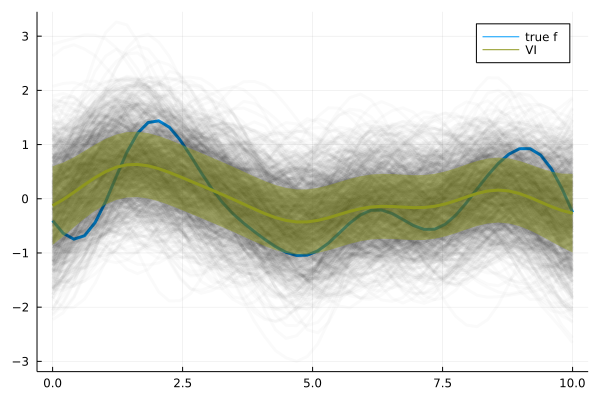

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

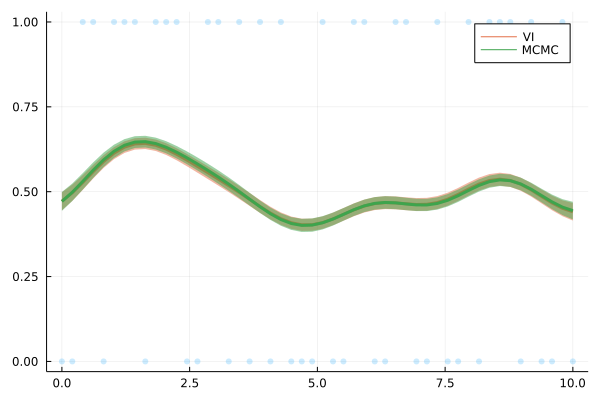

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*